# Deep Learning SABR Models

ToDo:
* Training does not lead to enough points within demo-feasible time. Move to training from tsv data?
* But if we do this, then we can no longer compare against a closed-form on the sheet. So that's the point where we'd need a Python library through pip install? Past colabs show that doing Python MC seems feasible, especially since those 100 points we display are all at the same time and under the same parameters. So we can get them by doing only 1 simulation that calculates 100 products. Shall we also do it across time?
* Split the testing set into training and validation sets.
* Do it for FBSABR, ZABR, etc... this is more easily usable for Cheyette.
* Possibly implement MC to compare against network, which then allows us to do FBSABR
* During the inverse map, the price function can be used again to check the accuracy of the parameters found by the map.
* Wrap SABR price sample generation in function to use it more easily vs simply reading prices from text?
* Should we use put prices rather than call? Would have less noise in MC.



In [ ]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import scipy.stats
import sklearn as sk
from platform import python_version
import time as tm
import matplotlib.pyplot as plt
import math
import warnings
# from sklearn.metrics import mean_squared_error

# Install and import PySABR
#!pip install pysabr
#import pysabr

print("Python version: " + python_version())
print("TensorFlow version: " + tf.__version__)
print("TF-Keras version: " + tf.keras.__version__)
print("NumPy version: " + np.__version__)
print("SciPy version: " + scipy.__version__)
print("SciKit version: " + sk.__version__)

Python version: 3.9.16
TensorFlow version: 2.11.0
TF-Keras version: 2.11.0
NumPy version: 1.22.4
SciPy version: 1.10.1
SciKit version: 1.2.2


## 1) Preliminaries

In this section we introduce various global settings and helper functions.

In [ ]:
# Global settings
shift = 0.03  # To account for negative rates in the SABR model
beta = 0.5  # Fixed to avoid the parameter redundancy
dtype = 'float32'
np.seterr(all='warn')
warnings.filterwarnings('error')

### a) Price function

We define the price function under the chosen stochastic model. In this work we choose the SABR model as approximated by the classic formula by Hagan, with a shift to account for negative rates.

Note that this is only for illustration purposes. In practice the work presented here is intended to be used with other stochastic models, primarily those that do not have a readily available robust and exact closed-form. In such cases, the pricing function may be obtained by numerical methods such as Monte-Carlo or Finite Differences, which will be typically too slow for optimization/calibration.

This pricing function will be used repeatedly to prepare the training dataset. The advantage of the method is that the large effort in runtime due to the slow pricing function is off-loaded to the training phase, while in the daily pricing phase the network is used for very fast evaluation.

In [ ]:
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr import black

def price_function(expiry, fwd, strike, alpha, nu, rho):
    vol = sabr.lognormal_vol(strike + shift, fwd + shift, expiry, alpha, beta, rho, nu)
    r = 0.0  # Use forward prices (0 discount rate)
    fwd_price = black.lognormal_call(strike + shift, fwd + shift, expiry, vol, r)
    return fwd_price

### b) Inversion to normal vols

Although we could use forward prices directly as outputs to train the network, using normal volatilities instead allows us to avoid the need to fit to the known instrinc value.

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize, minimize_scalar

def bachelier_price(expiry, fwd, strike, vol):
    stdev = vol * expiry**0.5
    d = (fwd - strike) / stdev
    price = stdev * (d * norm.cdf(d) + norm.pdf(d))
    return price

# Direct method by numerical inversion using Brent
def price_to_nvol(expiry, fwd, strike, price):
    options = {'xtol': 1e-4, 'maxiter': 100, 'disp': False}
    xmin = 1e-6
    xmax = 1.0

    def error(vol):
        premium = bachelier_price(expiry, fwd, strike, vol)
        return (premium - price) ** 2

    res = minimize_scalar(fun=error, bracket=(xmin, xmax), options=options, method='brent')

    return res.x

# P. Jaeckel's method in "Implied Normal Volatility", 6th Jun. 2017
def price_to_nvol_jaeckel(expiry, fwd, strike, price, is_call=True):
    # Special case at ATM
    if np.abs(fwd - strike) < 1e-8:
        return price * np.sqrt(2.0 * np.pi) / np.sqrt(expiry)

    # General case
    tilde_phi_star_C = -0.001882039271
    theta = 1.0 if is_call else -1.0

    tilde_phi_star = -np.abs(price - np.maximum(theta * (fwd - strike), 0.0) ) / np.abs(fwd - strike)
    em5 = 1e-5

    if tilde_phi_star < tilde_phi_star_C:
        g = 1.0 / (tilde_phi_star - 0.5)
        g2 = g**2
        em3 = 1e-3
        num = 0.032114372355 - g2 * (0.016969777977 - g2 * (2.6207332461 * em3 - 9.6066952861 * em5 * g2))
        den = 1.0 - g2 * (0.6635646938 - g2 * (0.14528712196 - 0.010472855461 * g2))
        eta_bar = num / den
        xb = g * (eta_bar * g2 + 1.0 / np.sqrt(2.0 * np.pi))
    else:
        h = np.sqrt(-np.log(-tilde_phi_star))
        num = 9.4883409779 - h * (9.6320903635 - h * (0.58556997323 + 2.1464093351 * h))
        den = 1.0 - h * (0.65174820867 + h * (1.5120247828 + 6.6437847132 * em5 * h))
        xb = num / den

    q =  (norm.cdf(xb) + norm.pdf(xb) / xb - tilde_phi_star) / norm.pdf(xb)
    xb2 = xb**2
    num = 3.0 * q * xb2 * (2.0 - q * xb * (2.0 + xb2))
    den = 6.0 + q * xb * (-12.0 + xb * (6.0 * q + xb * (-6.0 + q * xb * (3.0 + xb2))))
    xs = xb + num / den
    sigma = np.abs(fwd - strike) / (np.abs(xs) * np.sqrt(expiry))
    return sigma

### c) Network helper class

We will use Tensorflow's Keras models for training. Scaling of the inputs/outputs is often helpful for convergence. For convenience, here we define a wrapper class for Keras models which provides a simpler interface to evaluate models with scalers.

In [ ]:
from sklearn.preprocessing import StandardScaler

# LearningModel class, which incorporates the Keras model and its scalers in a single interface
class LearningModel:
    def __init__(self, model):
        self.model = model
        self.x_scaler = StandardScaler(copy=True)
        self.y_scaler = StandardScaler(copy=True)
        self.is_scaled = False
        # self.epochs = []
        # self.losses = []
        # self.accuracies = []
        # self.offset = 0

    def train(self, x_set, y_set, epochs, batch_size):  #, call_back):
        if not self.is_scaled:  # Then we scale the inputs and outputs
            self.x_scaler.fit(x_set)
            self.y_scaler.fit(y_set)
            # call_back.set_scalers(self.x_scaler, self.y_scaler)
            self.is_scaled = True

        x_scaled = self.x_scaler.transform(x_set)
        y_scaled = self.y_scaler.transform(y_set)

        history = self.model.fit(x_scaled, y_scaled, epochs=epochs, batch_size=batch_size, shuffle=True,
                                 verbose=1)#, callbacks=[call_back])

        return history

        # epochs, accuracies = call_back.convergence()

        # self.losses.extend(history.history['loss'])
        # self.accuracies.extend(accuracies)

        # num_epochs = len(epochs)
        # for i in range(num_epochs):
        #     self.epochs.append(self.offset + epochs[i])

        # self.offset += num_epochs

    def predict(self, x_test):
        x_scaled = self.x_scaler.transform(x_test)
        y_scaled = self.model(x_scaled)
        y_test = self.y_scaler.inverse_transform(y_scaled)
        return y_test

    # def convergence(self):
    #     return self.epochs, self.losses, self.accuracies

    # def clear_training(self):
    #     self.epochs.clear()
    #     self.losses.clear()
    #     self.accuracies.clear()
    #     self.offset = 0


# Custom learning rate scheduler, exponentially decreases between given values
class FlooredExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-1, final_lr=1e-4, decay=0.96, decay_steps=100):
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.decay = decay
        self.decay_steps = decay_steps

    def __call__(self, step):
        ratio = tf.cast(step / self.decay_steps, tf.float32)
        coeff = tf.pow(self.decay, ratio)
        return self.initial_lr * coeff + self.final_lr * (1.0 - coeff)

    def get_config(self):
        config = { 'initial_lr': self.initial_lr,
                   'final_lr': self.final_lr,
                   'decay': self.decay,
                   'decay_steps': self.decay_steps }
        return config


# Adding layers
kinits = tf.keras.initializers
klayers = tf.keras.layers

def add_hidden_layer(model_, neurons_, activation_):
    init = kinits.glorot_normal

    model_.add(klayers.Dense(neurons_, activation=activation_, kernel_initializer=init,
                             use_bias=True, bias_initializer=kinits.Constant(0.1)))
    

# Set up the network architecture
def compose_model(dimension_, hidden_layers_, num_neurons_, dropout_=0.2):
    model_ = tf.keras.Sequential()

    # multi-d inputs
    model_.add(tf.keras.Input(dimension_))

    # Hidden layers
    for hl in hidden_layers_:
        add_hidden_layer(model_, num_neurons_, hl)
        model_.add(klayers.Dropout(dropout_))

    # 1d outputs
    model_.add(klayers.Dense(1))

    return model_

## 2) Direct map

In the direct map, the network's inputs are the stochastic model's parameters and the outputs are the option prices. Such a network essentially learns the pricing function. It can be used to price vanilla options or to optimize on in order to calibrate the stochastic model parameters.

### a) Generate the dataset

The inputs consists of the stochastic model's parameters together with the expiry, the forward, and a strike. The outputs are the normal volatility

In [ ]:
num_samples = 100000

rngSeed = 42
rng = np.random.RandomState(rngSeed)

t0 = tm.time()
# Generate inputs
expiry = rng.uniform(1.0 / 12.0, 5.0, (num_samples, 1))
fwd = rng.uniform(-0.01, 0.04, (num_samples, 1))
ln_vol = rng.uniform(0.05, 0.25, (num_samples, 1))  # Specify log-normal vol
alpha = ln_vol * np.power(np.abs(fwd + shift), 1 - beta)  # Rough order of magnitude for alpha
nu = rng.uniform(0.20, 0.80, (num_samples, 1))
rho = rng.uniform(-0.40, 0.40, (num_samples, 1))
spread = rng.uniform(-300, 300, (num_samples, 1))  # Specify spreads in bps
strike = fwd + spread / 10000
print('Generate inputs: {:.3f} seconds'.format(tm.time() - t0))

# Generate outputs
t0 = tm.time()
fv = np.ndarray((num_samples, 1))
for i_ in range(num_samples):
    fv[i_, 0] = price_function(expiry[i_, 0], fwd[i_, 0], strike[i_, 0], alpha[i_, 0], nu[i_, 0], rho[i_, 0])

print('Generate prices: {:.3f} seconds'.format(tm.time() - t0))

t0 = tm.time()
normal_vol = []
for i_ in range(num_samples):
    try:
        normal_vol.append(price_to_nvol_jaeckel(expiry[i_, 0], fwd[i_, 0], strike[i_, 0], fv[i_, 0]))
    except Exception:
        normal_vol.append(-12345.6789)

print('Inversion: {:.3f} seconds'.format(tm.time() - t0))


# Create input set
x_set_raw = np.column_stack((expiry, fwd, strike, alpha, nu, rho))

# Filter out bad data and create output set
t0 = tm.time()
min_vol = 0.0001
max_vol = 0.1

x_set = []
y_set = []
for i in range(num_samples):
    nvol = normal_vol[i]
    if math.isnan(nvol) == False and nvol > min_vol and nvol < max_vol:
        x_set.append(x_set_raw[i])
        y_set.append(nvol)

print('Cleansing: {:.3f} seconds'.format(tm.time() - t0))

# Reshape
x_set = np.asarray(x_set)
y_set = np.asarray(y_set)
y_set = y_set.reshape((y_set.shape[0], 1))

# Display information
in_dimension = x_set.shape[1]
out_dimension = y_set.shape[1]
print("Input dimension: " + str(in_dimension))
print("Output dimension: " + str(out_dimension))
print("Dataset size: " + str(x_set.shape[0]))

Generate inputs: 0.024 seconds
Generate prices: 26.025 seconds
Inversion: 35.255 seconds
Cleansing: 0.070 seconds
Input dimension: 6
Output dimension: 1
Dataset size: 99196


### b) Initialize the network

In [ ]:
# Tested activations: tanh, softplus, softmax, relu, selu, elu, sigmoid
hidden_layers = ['softplus', 'softplus', 'softplus']
num_neurons = 16

# Create model
dropout = 0.00
keras_model = compose_model(in_dimension, hidden_layers, num_neurons, dropout)

# Learning rate scheduler
init_lr = 1e-1
final_lr = 1e-4
decay = 0.97
steps = 100
lr_schedule = FlooredExponentialDecay(init_lr, final_lr, decay, steps)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile
keras_model.compile(loss='mse', optimizer=optimizer)
model = LearningModel(keras_model)

# Display optimizer fields
print("Optimizer settings")
optim_fields = optimizer.get_config()
for field in optim_fields:
    print(field, ":", optim_fields[field])

# Record loss and learning rate
# loss_hist = []
# lr_hist = []

Optimizer settings
name : Adam
weight_decay : None
clipnorm : None
global_clipnorm : None
clipvalue : None
use_ema : False
ema_momentum : 0.99
ema_overwrite_frequency : None
jit_compile : False
is_legacy_optimizer : False
learning_rate : {'class_name': 'FlooredExponentialDecay', 'config': {'initial_lr': 0.1, 'final_lr': 0.0001, 'decay': 0.97, 'decay_steps': 100}}
beta_1 : 0.9
beta_2 : 0.999
epsilon : 1e-07
amsgrad : False


### c) Train the network

In [ ]:
# Train the network
epochs = 1000
batch_size = 1000
history = model.train(x_set, y_set, epochs, batch_size)

Epoch 1/1000
100/100 [==============================] - 2s 4ms/step - loss: 1.2877
Epoch 2/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.6907
Epoch 3/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.3551
Epoch 4/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.2542
Epoch 5/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.2243
Epoch 6/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.1756
Epoch 7/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.1741
Epoch 8/1000
100/100 [==============================] - 1s 5ms/step - loss: 0.1710
Epoch 9/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.1905
Epoch 10/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.1241
Epoch 11/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.1268
Epoch 12/1000
100/100 [==============================] - 0s 4ms/step - loss: 0.1092
E

### d) View the results

In [ ]:
# Generate strike axis
num_points = 100
spread_grid = np.linspace(-300, 300, num=num_points)

# View one slice
def check_vol_slice(model, fwd, expiry, ln_vol, nu, rho):
    alpha = ln_vol * (fwd + shift)**(1.0 - beta)
    strikes = fwd + spread_grid / 10000.0
    expiries = np.ones(shape=(num_points, 1)) * expiry
    fwds = np.ones(shape=(num_points, 1)) * fwd
    alphas = np.ones(shape=(num_points, 1)) * alpha
    nus = np.ones(shape=(num_points, 1)) * nu
    rhos = np.ones(shape=(num_points, 1)) * rho
    disp_points = np.column_stack((expiries, fwds, strikes, alphas, nus, rhos))
    md_vols = model.predict(disp_points)

    cf_vols = []
    for strike in strikes:
        cf_price = price_function(expiry, fwd, strike, alpha, nu, rho)
        cf_vols.append(price_to_nvol_jaeckel(expiry, fwd, strike, cf_price, is_call=True))
    return cf_vols, md_vols
    # rmse = utils.rmse(smile_cf, smile_nn)
    # plot_sabr_smile(k, smile_cf, smile_nn, alpha, beta, nu, rho, f, t, rmse)

[0.016256786360639947, 0.01620848856408182, 0.016159980422081513, 0.016111290321014694, 0.016062446846925985, 0.01601347883666231, 0.015964415427632644, 0.015915286106254038, 0.01586612075511763, 0.015816949698886303, 0.015767803748900234, 0.015718714246447246, 0.01566971310462188, 0.015620832848670382, 0.015572106654687492, 0.015523568386501553, 0.015475252630552437, 0.015427194728532044, 0.015379430807526977, 0.015331997807365749, 0.015284933504838897, 0.015238276534426332, 0.015192066405130012, 0.015146343512977185, 0.015101149148726114, 0.015056525500276304, 0.01501251564925723, 0.014969163561247622, 0.014926514069056877, 0.014884612848490974, 0.014843506386020345, 0.014803241937772311, 0.014763867479288716, 0.01472543164551657, 0.01468798366054422, 0.014651573256653224, 0.014616250582331663, 0.014582066098988652, 0.014549070466221063, 0.014517314415615826, 0.014486848613220001, 0.014457723510980675, 0.014429989187639797, 0.014403695179769726, 0.014378890303844566, 0.01435562247045

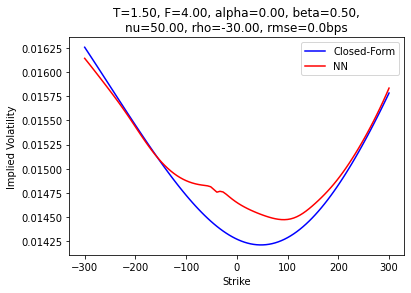

In [ ]:
expiry = 1.5
fwd = 0.04
ln_vol = 0.20
nu = 0.50
rho = -0.30

cf_vols, md_vols = check_vol_slice(model, fwd, expiry, ln_vol, nu, rho)
print(cf_vols)

# Plot
rmse = 0.0
alpha = 0.0
plt.title('T=%.2f' % expiry + ', F=%.2f' %(fwd*100) + ', alpha=%.2f' %(alpha * 100) + ', beta=%.2f' %beta + ',\n' +
          'nu=%.2f' %(nu*100) + ', rho=%.2f' %(rho * 100) + ', rmse=%.1f' %rmse + 'bps')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.plot(spread_grid, cf_vols, color='blue', label='Closed-Form')
plt.plot(spread_grid, md_vols, color='red', label='NN')
plt.legend(loc='upper right')



In [ ]:
# x_set_raw = np.column_stack((expiry, fwd, strike, alpha, nu, rho))
num_points = 4
expiries = np.ones(shape=(num_points, 1)) * expiry
fwds = np.ones(shape=(num_points, 1)) * fwd
alphas = np.ones(shape=(num_points, 1)) * alpha
nus = np.ones(shape=(num_points, 1)) * nu
rhos = np.ones(shape=(num_points, 1)) * rho
disp_points = np.column_stack((expiries, fwds))
print(disp_points.shape)
print(disp_points)


(4, 2)
[[1.5  0.04]
 [1.5  0.04]
 [1.5  0.04]
 [1.5  0.04]]


## 3) Inverse map

In [ ]:
# Strike grid expressed as spreads to ATM
strike_grid = [-200, -100, -50, -25, 0, 25, 50, 100, 200]

## A) Tests on PySABR

In [ ]:
# from pysabr import Hagan2002LognormalSABR

# fwd = 0.025
# expiry = 1.0
# normal_vol = 0.004
# beta = 0.5
# rho = -0.2
# volvol = 0.30
# sabr = Hagan2002LognormalSABR(fwd, shift, expiry, normal_vol, beta, rho, volvol)

# k = 0.025
# iv = sabr.lognormal_vol(k) * 100
# print(iv)

# strikes = [0.01, 0.02, 0.03, 0.04]
# ivs = [sabr.lognormal_vol(s) * 100 for s in strikes]
# print(ivs)